In [1]:
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install chaospy
!{sys.executable} -m pip install sklearn
from sklearn.metrics import mean_squared_error
import numpy
import chaospy as ch
from matplotlib import pyplot

     |████████████████████████████████| 10.3 MB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 48.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 68.4 MB/s eta 0:00:01
     |████████████████████████████████| 15.3 MB 36.7 MB/s eta 0:00:01
     |████████████████████████████████| 247 kB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 28.5 MB 134 kB/s eta 0:00:01
     |████████████████████████████████| 22.3 MB 4.1 MB/s eta 0:00:01███████████████████████▊      | 17.9 MB 4.1 MB/s eta 0:00:02
     |████████████████████████████████| 303 kB 60.1 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=de9870848c6716b03587ae35f233ec71af3dd2416c9930bd56889b7b4eb3254a
  Stored in directory: /home/jovyan/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [31]:
class liftCompRho(): 
    def __init__(self,Cl,A,v):
        self.CL = Cl
        self.A = A
        self.v = v
    def compute(self,rho):
        return (.5 * self.CL * self.A * rho * self.v**2)
    
class liftCompV(): 
    def __init__(self,Cl,A,rho):
        self.CL = Cl
        self.A = A
        self.rho = rho
    def compute(self,v):
        return (.5 * self.CL * self.A * self.rho * v**2)

In [32]:
distr = ch.Normal(2,.3)
samples = distr.sample(1e5)
print(samples)
lift = liftCompRho(.3,1,1)
#lift = liftCompV(.3,1,1)

[1.96858529 2.08428196 1.9684098  ... 2.11202287 2.26204316 1.80670096]


In [33]:
obs = [lift.compute(i) for i in samples]
print(obs[0:10])

[0.29528779348277057, 0.31264229434637136, 0.2952614699839537, 0.23717620622202745, 0.2068161493702736, 0.23568738244491447, 0.2177165398100671, 0.2417513371763404, 0.31119461840913026, 0.2771728778195908]


E 0.2999656800053388
sd 0.04517924198621308


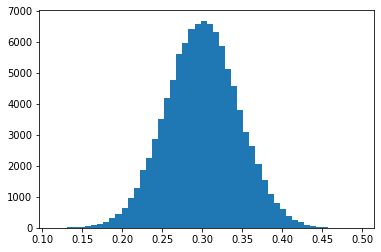

In [34]:
pyplot.hist(obs,bins=50)
E = numpy.mean(obs)
std = numpy.std(obs)
print("E " + str(E))
print("sd "+ str(std))

In [35]:
class quadrature():
    def __init__(self,distr):
        self.distr = distr 
    def makeQuadrature(self,order, rule="undefined", growth=False):
        self.rule = rule
        self.order = order
        self.growth =growth
        if isinstance(order, list):
            self.quadrature = [ch.generate_quadrature(ord, self.distr, rule=rule,growth= growth) for ord in order]
        else:
            self.quadrature = ch.generate_quadrature(order, self.distr, rule=rule,growth= growth)
    def plot(self):
        pyplot.subplot()
        pyplot.title(self.rule + " Growth " + str(self.growth))
        if len(self.order)>1:
            p= [pyplot.scatter(quad[0],[ordi] *quad[0].size,s=quad[1]*1e3) for ordi,quad in zip(self.order, self.quadrature)]
        else:
            p = pyplot.scatter(self.quadrature[0],[self.order]*self.quadrature[0].size,s=self.quadrature[1]*1e3)
        return p
    def observe(self, model):
        obs = []
        for nodes in self.quadrature:
            obs.append([model(node) for node in nodes[0]])
            self.observations = obs
        return obs

In [36]:
distrProxy = distr
#distrProxy = ch.Normal(E-std*.3,E*std*.3)
#distrProxy = ch.Uniform(100-.3*3,100+.3*3)
print(distrProxy)

Normal(mu=2, sigma=0.3)


In [37]:
quadGauss = quadrature(distrProxy)
quadClenGrowth = quadrature(distrProxy)
quadGaussGrowth = quadrature(distrProxy)
quadClen = quadrature(distrProxy)

In [39]:
quadGauss.makeQuadrature([1,2,3,4], rule = "G")
quadGaussGrowth.makeQuadrature([1,2,3,4], rule = "G",growth=True)
quadClen.makeQuadrature([1,2,3,4],rule = "clenshaw_curtis",growth=False)
quadClenGrowth.makeQuadrature([1,2,3,4],rule = "clenshaw_curtis",growth=True)

In [47]:
print("nodes")
print(quadGauss.quadrature[1][0])
print("weigths")
print(quadGauss.quadrature[1][1])

nodes
[[1.48038476 2.         2.51961524]]
weigths
[0.16666667 0.66666667 0.16666667]


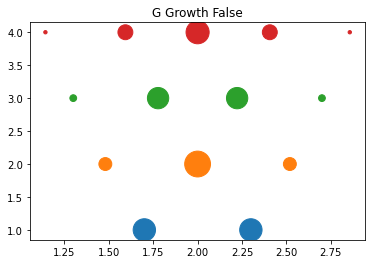

In [48]:
quadGauss.plot()

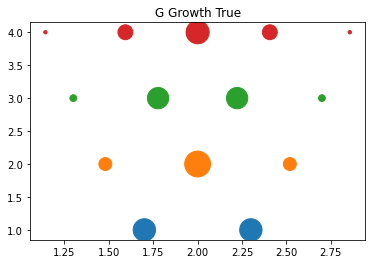

In [49]:
quadGaussGrowth.plot()

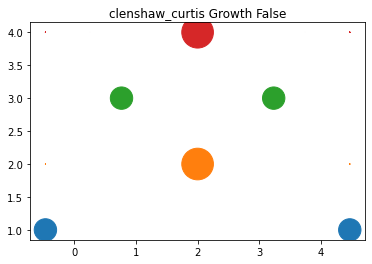

In [50]:
quadClen.plot()

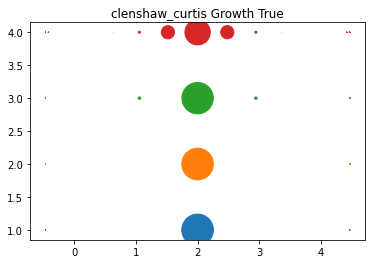

In [51]:
quadClenGrowth.plot()

In [16]:
expansion = [ch.generate_expansion(order, distrProxy)for order in range(1, 5)]
expansion

[polynomial([1.0, q0-2.0]),
 polynomial([1.0, q0-2.0, q0**2-4.0*q0+3.91]),
 polynomial([1.0, q0-2.0, q0**2-4.0*q0+3.91, q0**3-6.0*q0**2+11.73*q0-7.46]),
 polynomial([1.0, q0-2.0, q0**2-4.0*q0+3.91, q0**3-6.0*q0**2+11.73*q0-7.46,
             q0**4-8.0*q0**3+23.46*q0**2-29.840000000000003*q0+13.8643])]

In [17]:
quadGauss.observe(lift.compute)
quadClen.observe(lift.compute)

[[array([0.0325734, 2.9917734])],
 [array([0.0325734, 0.6      , 2.9917734])],
 [array([0.0325734 , 0.08824335, 1.56784335, 2.9917734 ])],
 [array([0.0325734 , 0.00985151, 0.6       , 2.10232189, 2.9917734 ])]]

In [18]:
mod= [ch.fit_quadrature(expansion[ind],quadGauss.quadrature[ind][0] , quadGauss.quadrature[ind][1], quadGauss.observations[ind][0]) for ind in range(0, 4)]
[print(str(m.round(3)) + "\n Exp "+ str(ch.E(m, distrProxy)-E) + " STD "+ str(ch.Std(m, distrProxy)-std) ) for m in mod]

0.6*q0-0.586
 Exp -8.34409724131957e-05 STD -0.0009203034055677017
0.15*q0**2
 Exp -8.344097241308468e-05 STD 8.936484450131066e-05
0.15*q0**2
 Exp -8.344097241308468e-05 STD 8.936484450183801e-05
0.15*q0**2
 Exp -8.344097241330672e-05 STD 8.936484450119964e-05


[None, None, None, None]

In [19]:
mod2= [ch.fit_quadrature(expansion[ind],quadClen.quadrature[ind][0] , quadClen.quadrature[ind][1], quadClen.observations[ind][0]) for ind in range(0, 4)]
[print(str(m.round(3)) + "\n Exp "+ str(ch.E(m, distrProxy)-E) + " STD "+ str(ch.Std(m, distrProxy)-std) ) for m in mod2]

0.6*q0+0.312
 Exp 0.8985899590275971 STD -0.0009203034055664805
-6.667*q0**2+27.267*q0-26.667
 Exp -0.013583440972411709 STD 0.6864896342783419
0.48*q0**3-2.3*q0**2+3.913*q0-1.688
 Exp 0.21445990902843304 STD 0.016150687327103647
24.544*q0**4-196.131*q0**3+567.825*q0**2-702.573*q0+311.998
 Exp -0.01358341292789389 STD 1.1233198512657452


[None, None, None, None]

In [20]:
pc_model_approx =[ch.fit_regression(expansion[ind],quadGauss.quadrature[ind][0] , quadGauss.observations[ind][0]) for ind in range(0, 4)]
[print(str(m.round(3)) + "\n Exp "+ str(ch.E(m, distrProxy)-E) + " STD "+ str(ch.Std(m, distrProxy)-std) ) for m in pc_model_approx]

0.6*q0-0.587
 Exp -8.344097241330672e-05 STD -0.0009203034055677017
0.15*q0**2
 Exp -8.344097241286264e-05 STD 8.936484450117188e-05
0.15*q0**2
 Exp -8.344097241330672e-05 STD 8.936484450158821e-05
0.15*q0**2
 Exp -8.344097241286264e-05 STD 8.93648445017825e-05


[None, None, None, None]

In [21]:
pc_model_approx =[ch.fit_regression(expansion[ind],quadClen.quadrature[ind][0] , quadClen.observations[ind][0]) for ind in range(0, 4)]
[print(str(m.round(3)) + "\n Exp "+ str(ch.E(m, distrProxy)-E) + " STD "+ str(ch.Std(m, distrProxy)-std) ) for m in pc_model_approx]

0.6*q0+0.312
 Exp 0.8985899590275869 STD -0.0009203034055677017
0.15*q0**2
 Exp -8.344097241286264e-05 STD 8.936484450131066e-05
0.15*q0**2
 Exp -8.344097241286264e-05 STD 8.93648445010331e-05
0.15*q0**2
 Exp -8.344097241330672e-05 STD 8.936484450064452e-05


[None, None, None, None]

In [26]:
sobol_samples = [ch.create_sobol_samples(i,1)*1.35 for i in range(1,8)]

In [27]:
sobol_obs = [lift.compute(i) for s in sobol_samples for i in s]
sobol_obs

[array([0.06834375]),
 array([0.06834375, 0.15377344]),
 array([0.06834375, 0.15377344, 0.01708594]),
 array([0.06834375, 0.15377344, 0.01708594, 0.03844336]),
 array([0.06834375, 0.15377344, 0.01708594, 0.03844336, 0.20930273]),
 array([0.06834375, 0.15377344, 0.01708594, 0.03844336, 0.20930273,
        0.10678711]),
 array([0.06834375, 0.15377344, 0.01708594, 0.03844336, 0.20930273,
        0.10678711, 0.00427148])]

In [28]:
expansion = [ch.generate_expansion(order, distrProxy)for order in range(1, 9)]
sobol_mod =[ch.fit_regression(exp,samp , obs) for exp,samp , obs in zip(expansion,sobol_samples , sobol_obs)]
[print(str(m.round(3)) + "\n Exp "+ str(ch.E(m, distrProxy)-E) + " STD "+ str(ch.Std(m, distrProxy)-std) ) for m in sobol_mod]

-0.033*q0+0.091
 Exp -0.5887818986725719 STD -0.17106169034138077
-0.138*q0**2+0.487*q0-0.197
 Exp -0.4035232385334425 STD -0.15415408420087778
-0.103*q0**3+0.358*q0**2-0.129*q0+0.024
 Exp -0.260196978142721 STD -0.14495661404839089
-0.036*q0**4+0.09*q0**3+0.069*q0**2+0.031*q0-0.004
 Exp -0.15248390109632615 STD -0.11213327513228356
-0.014*q0**5+0.054*q0**4-0.076*q0**3+0.201*q0**2-0.016*q0+0.002
 Exp -0.0652140937783845 STD -0.06537551400357264
-0.005*q0**6+0.023*q0**5-0.042*q0**4+0.04*q0**3+0.129*q0**2+0.005*q0-0.001
 Exp -0.033118820889246225 STD -0.03954941848190485
-0.001*q0**7+0.007*q0**6-0.013*q0**5+0.013*q0**4-0.008*q0**3+0.152*q0**2
 Exp -0.020236473336096017 STD -0.02679077810046357


[None, None, None, None, None, None, None]

In [29]:
sobolMC = [sob_mod(samples) for sob_mod in sobol_mod ]

In [30]:
[print("Exp "+ str(numpy.mean(m)- E) + " STD "+ str(numpy.std(m)-std) ) for m in sobolMC]

Exp -0.588786366064549 STD -0.17106100686967643
Exp -0.40353409675981033 STD -0.1542086166531853
Exp -0.2601701806934441 STD -0.14480567494400434
Exp -0.15241638478919867 STD -0.11187701291472434
Exp -0.06511584564364559 STD -0.06517733095861274
Exp -0.03301681392249667 STD -0.03942772654076607
Exp -0.020138605234503948 STD -0.026723617766223673


[None, None, None, None, None, None, None]